# Modèle GARCH

## Introduction

Le modèle GARCH (Generalized Autoregressive Conditional Heteroskedasticity) est une approche statistique utilisée pour modéliser et estimer la volatilité conditionnelle des rendements financiers.

Cette méthode s'avère particulièrement utile pour capturer les variations temporelles de la volatilité, ce qui est crucial dans l'évaluation des risques financiers et dans la modélisation des prix des actifs.

## Objectif

Le principal objectif du modèle GARCH est de modéliser la volatilité conditionnelle, c'est-à-dire la variation de la volatilité au fil du temps en fonction de l'information disponible jusqu'à ce moment. 

Il tient compte de l'hétéroscédasticité conditionnelle, une caractéristique observée dans les données financières où la volatilité change au fil du temps.

## Principe

Le modèle GARCH repose sur l'idée que la variance d'une série temporelle financière peut être modélisée comme une combinaison linéaire de ses valeurs passées et de ses erreurs passées. Ainsi, la volatilité conditionnelle à un instant donné dépend des rendements passés et des erreurs passées. Le modèle ajuste les paramètres pour minimiser l'erreur entre la volatilité estimée et la volatilité observée.

$$
\sigma_{t}^{2} = \omega + \sum_{i=1}^p \alpha_{i}\epsilon_{t-i}^{2} + \sum_{j=1}^q\beta{j}\sigma_{t-j}^{2}
$$

Où :
- $\sigma_{t}^{2}$ est la volatilité conditionnelle à l'instant t
- p (ordre autorégressif) : le nombre de rendements passés utilisés pour modéliser la volatilité conditionnelle.
- q (ordre de la moyenne mobile) : le nombre d'erreurs passées utilisées pour le même but.
- $\epsilon_{t}$ est l'erreur à l'instant t
- $\omega, \alpha_{i}, \beta{j}$ sont les paramètres à estimer.

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

In [ ]:
# Télécharger les données de S&P 500
ticker = "^GSPC"
start_date = "2010-01-01"
end_date = "2024-01-01"
spx = yf.download(ticker, start=start_date, end=end_date)

# Calculer les rendements
returns = np.log(spx['Close'] / spx['Close'].shift(1)).dropna()


In [ ]:
# Ajuster un modèle GARCH(1,1)
model = arch_model(returns, vol='Garch', p=1, q=1)
results = model.fit()

# Afficher les résultats (la moyenne conditionnelle, les estimateurs)
print(results.summary())

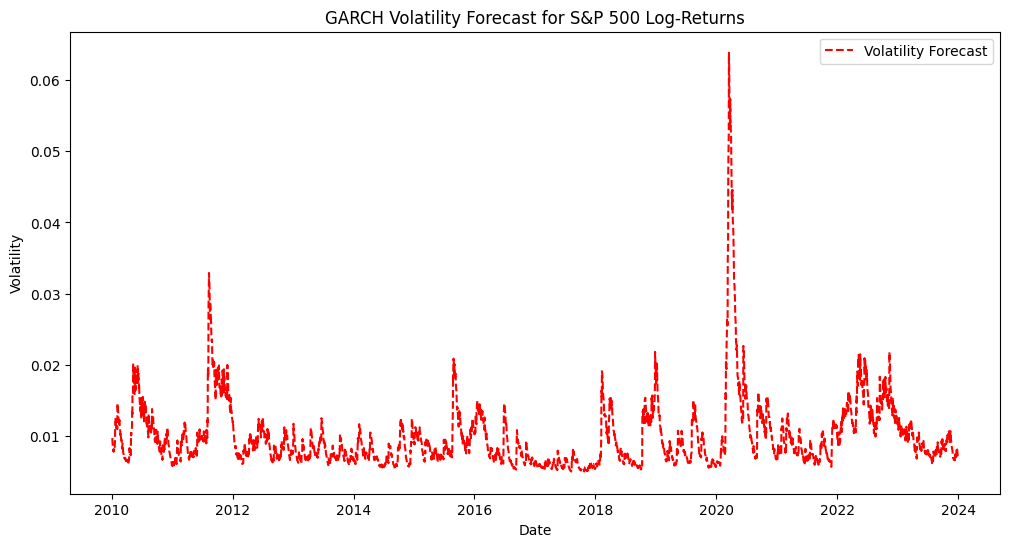

In [40]:
# Prédire la volatilité future
volatility_forecast = results.conditional_volatility

# Visualiser les résultats
plt.figure(figsize=(12, 6))
plt.plot(volatility_forecast.index, volatility_forecast, label='Volatility Forecast', linestyle='--', color='red')
plt.title('GARCH Volatility Forecast for S&P 500 Log-Returns')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()